In [159]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy
from HessianMCMC import HessianMCMC

tfb = tfp.bijectors
tfd=tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [160]:
def constant64(i):
    return(tf.constant(i,dtype = tf.float64))

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [161]:
def divide(a,b):
    '''
     Tensorflow safe divide
    '''
    return tf.math.divide_no_nan(a,b)

def A(x1,z1,x2,z2):
    numerator = (x2-x1)*(x1*z2-x2*z1)
    denominator = (x2-x1)**2 + (z2-z1)**2
    return divide(numerator,denominator)

def B(x1,z1,x2,z2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return divide((z1-z2),(x2-x1))


def theta_new(xn,zn):
    
    m = tf.atan(divide(zn,xn))

    m = tf.where(m<0, m + pi, m ) 

    m = tf.where(m == 0, m + pi/2, m)

    return m
 
    
def Z_new(x1,z1,x2,z2):
    
    ## let's do not allow 1) points at origin
    ##                    2) two points in a sequence have the same x coordinate
    
    
    theta1 = theta_new(x1,z1)
    theta2 = theta_new(x2,z2)
    
    r1 = (tf.sqrt(x1**2.+z1**2.))
    r2 = (tf.sqrt(x2**2.+z2**2.))

    _A = A(x1,z1,x2,z2)
    _B = B(x1,z1,x2,z2)
    
    
    Z_result = _A*((theta1-theta2)+_B*tf.math.log(divide(r1,r2)))
    

    return Z_result 
 
@tf.function
def grav_new(x,z):
    
    
    thick = thickness
    x_obv = tf.linspace(Range[0],Range[1],obs_N)
    y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float64)
    
    
    tx = tf.transpose(tf.tile(x,[1,obs_N]))

    x_tile = tf.expand_dims(tx,axis = 2)

    tz = tf.transpose(tf.tile(z,[1,obs_N]))

    z_tile = tf.expand_dims(tz,axis = 2)
    
    
    x_obv_tile = tf.expand_dims(x_obv,axis = 1)
    x_obv_tile = tf.tile(x_obv_tile,[1,x.shape[0]])
    x_obv_tile = tf.reshape(x_obv_tile,[obs_N,x.shape[0],1])


    z_obv_tile = tf.expand_dims(y_obv,axis = 1)
    z_obv_tile = tf.tile(z_obv_tile,[1,x.shape[0]])
    z_obv_tile = tf.reshape(z_obv_tile,[obs_N,x.shape[0],1])
    
    
    _x = x_tile - x_obv_tile
    _z = z_tile - z_obv_tile
    
    x_ = tf.concat([_x, tf.reshape(_x[:,0],shape = [obs_N,1,1])],axis = 1)
    z_ = tf.concat([_z, tf.reshape(_z[:,0],shape = [obs_N,1,1])],axis = 1)
    
    x1 = x_[:,0:-1]
    x2 = x_[:,1:]
    z1 = z_[:,0:-1]
    z2 = z_[:,1:]
    
    G = constant64(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = constant64(2000.)        # density difference   kg/m^3
    
    gravity = 2*G*rho*tf.reduce_sum(-Z_new(x1,z1,x2,z2),axis = 1)
    
    return tf.squeeze(gravity)


In [162]:

@tf.function
def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    
    Gm_ = grav_new(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
            +mvn_likelihood.log_prob(D))

@tf.function
def negative_log_posterior(D,_control_position):
    return -joint_log_post(D,_control_position)

In [163]:
## define some numbers
Number_para = 50
obs_N = 25
number_burnin = 3000
number_sample = 10000
steps_gradient_decent = 2000

pi = constant64(m.pi) # define PI in Tensorflow form

depth = constant64(-50)
thickness = constant64(10)

Range = constant64([-200.,200.])

In [164]:
# prior
mu_prior = -50.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 15.*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)


# likelihood
sig_e = constant64(2*1e-8)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

## Define the ground truth

In [165]:
tf.random.set_seed(8)

# X- values: uniformly distributed
control_index = tf.linspace(Range[0],Range[1],Number_para)
#control_index with non-even distribution
control_index = tf.linspace(Range[0],Range[1],Number_para)+tf.random.uniform([Number_para],-20,20,dtype = tf.float64)

# define some points to minimize the artifacts
number_of_fixpoints = 10

fix_point1 = tf.transpose(tf.stack([tf.linspace(Range[0]-200,Range[0]-10,number_of_fixpoints),depth*tf.ones(number_of_fixpoints,dtype = tf.float64)]))
fix_point2 = tf.transpose(tf.stack([tf.linspace(Range[1]+10,Range[1]+200,number_of_fixpoints),depth*tf.ones(number_of_fixpoints,dtype = tf.float64)]))

## define the true z-values
True_position = tf.random.normal([Number_para],depth,10,dtype = tf.float64)
True_position_sin = 10*tf.sin(0.04*control_index)+depth

#### Gaussian Process

In [166]:
## train the gp model based on True_position


# define x , z
points = tf.stack([control_index,True_position],axis = -1)


# add some points to eliminate the bondary artifacts
points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

## define the GP parameters
amplitude = tfp.util.TransformedVariable(
      2, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
      20, tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)
    
observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-1), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

# x- index used to construct GP model
observation_index_points = tf.reshape(points[:,0],[Number_para+2*number_of_fixpoints,1])


# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

# optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
# @tf.function
# def optimize():
#     with tf.GradientTape() as tape:
#         loss = -gp.log_prob(points[:,1])
#     grads = tape.gradient(loss, gp.trainable_variables)
#     optimizer.apply_gradients(zip(grads, gp.trainable_variables))
#     return loss
# # First train the model, then draw and plot posterior samples.
# for i in range(1000):
#     neg_log_likelihood_ = optimize()
    
    
model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],
                                         observation_index_points[-1,0],
                                         Number_para+4),
                             axis =1)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=model_index,
    observation_index_points=observation_index_points,
    observations=points[:,1],
    observation_noise_variance=observation_noise_variance)

model_position = gprm.mean()

model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,
                                                                axis = [-1])],
                                                axis = -1)],
                                         shape = [model_position.shape[0]*2,1])
model_index_complete = tf.concat([model_index,tf.reverse(model_index,
                                                         axis = [0])],
                                 axis = 0)

In [167]:
gp.trainable_variables

(<tf.Variable 'amplitude:0' shape=() dtype=float64, numpy=0.6931471805599453>,
 <tf.Variable 'length_scale:0' shape=() dtype=float64, numpy=2.995732273553991>,
 <tf.Variable 'observation_noise_variance:0' shape=() dtype=float64, numpy=-1.0>)

Exponentiated Quadratic Kernel

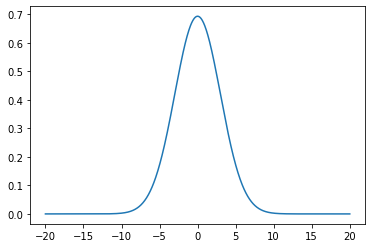

In [218]:
x = np.linspace(-20, 20, 1000)

plt.plot(x,gp.trainable_variables[0]*np.exp(-0.5*(x/gp.trainable_variables[1])**2))

In [168]:
def GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position):
    '''
        Arguments:
            kernel: trained GP kernal
            
        return:
            GP interpolated model index and model psition
            
    '''
    ## define how many points interpolated between control points
    resolution = 5
    
    
    points = tf.stack([_control_index,_control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)
    
    # x-index where we want to interpolate
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)

    model_position = gprm.mean()

    ## model_complete contains the extended polygon used to do gravity calculation
    model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,axis = [-1])],axis = -1)],
                                         shape = [model_position.shape[0]*2,1])

    model_index_complete = tf.concat([model_index,tf.reverse(model_index,axis = [0])],axis = 0)
    
    return model_index_complete,model_position_complete

x_true,z_true = GaussianProcess_model(kernel,observation_index_points,control_index,True_position_sin)

In [169]:
Data = grav_new(x_true,z_true)

In [170]:
joint_log_post(Data,True_position)

<tf.Tensor: shape=(), dtype=float64, numpy=-3698.991153661943>

In [171]:
def simulated_gravity(x,z,x_obs=None,Number_=obs_N ,R=Range[1],ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T

    gravity = grav_new(x,z)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')

    ax.set_xlim(-R,R)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

def Draw_inter(_control_index,_control_position,z_true = None,R = Range[1], ax = None):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is not None:
        ## true poistion is black
        ax.scatter(control_index,z_true, c = 'black',label = 'true position',alpha = 0.6)
        
    x_,z_ = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    ax.plot(x_,z_)
    ## proposal is red
    ax.scatter(control_index,_control_position, label = 'model position',c = 'red')

    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(depth-100,10)
    ax.set_xlim(-R,R)

In [172]:
# _x,_z = GaussianProcess_model(kernel,observation_index_points,control_index,True_position_sin)
# temp = np.zeros_like(_z)
# temp[0]= - 0.1;temp[-1] = 0.1
# temp[int(temp.shape[0]/2-1)] = -.1
# temp[int(temp.shape[0]/2)] = .1

# _z = _z+temp

# simulated_gravity(_x,_z)

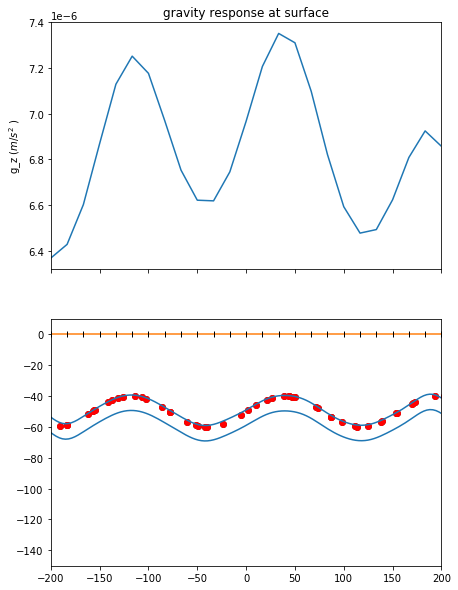

In [173]:
def Draw(_control_index,_control_position,ax = None,**args):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    _x,_z = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    simulated_gravity(_x,_z,ax = ax[0],**args)
    Draw_inter(_control_index,_control_position,ax = ax[1],z_true =True_position_sin)
Draw(control_index,True_position_sin)

In [174]:
mu_init = tf.random.normal([Number_para],mean = depth, stddev = -10,seed = 1,dtype = tf.float64) # initial parameters

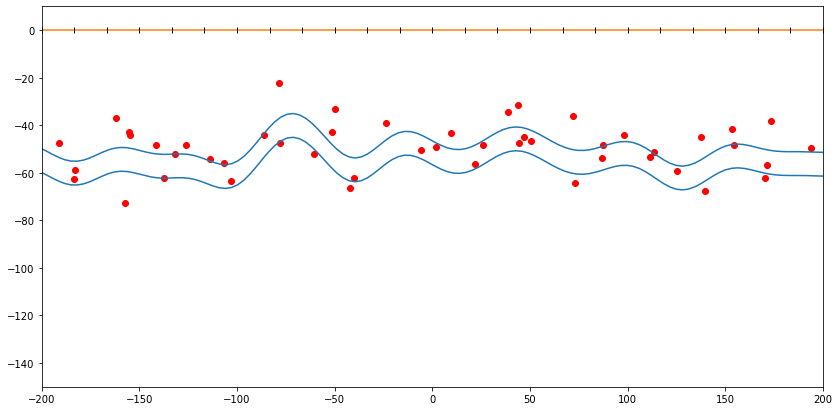

In [175]:
Draw_inter(control_index,mu_init)

loss tf.Tensor(2699.2410741974445, shape=(), dtype=float64)
grad tf.Tensor(
[ -6.51442989  -6.39813963   0.55638694 -13.003853   -11.02268493
 -11.14231742 -16.27807593 -11.01508399 -21.57260659 -19.70266262
 -21.3837743  -16.30525417 -16.29720192 -17.92286451   2.22363646
  23.82775708  26.21901707  25.10229167  24.66684966  40.30523224
  22.42615535  20.47351608  51.79318211  29.51504613  11.96359294
   0.77000144  -5.13929193  -4.30658137  -4.66228183  -6.14575223
  -5.93256565  -6.71745258  -4.7658824   -1.44374811   6.79908424
  -2.65226666   6.30112271  10.68431407   6.02231391   9.9119788
   9.72255525   1.86137879  -0.35930325 -12.97423319  -2.74141062
  -2.11237543 -13.55321344 -22.8591396  -14.39357715 -18.79943905], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-58.78510839 -62.42509535 -47.51005047 -72.77661937 -37.06442355
 -43.85962679 -48.11178478 -42.67304574 -48.14821824 -62.00665013
 -51.9986681  -55.85335311 -63.25235383 -54.1550097  -44.33156078
 -47.90144595 -43.0810

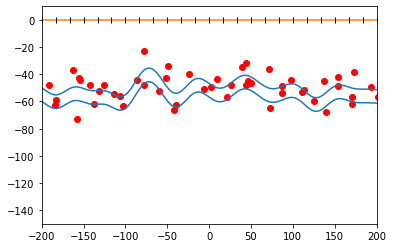

loss tf.Tensor(-191.27958082931764, shape=(), dtype=float64)
grad tf.Tensor(
[-2.09975895e-01 -3.32974821e-01  2.17377095e-01 -7.33311658e-01
  4.97949712e-01  2.54528058e-01  1.48262801e-01  2.95580218e-01
  2.40178671e-01 -2.96435091e-01  8.55398836e-02 -9.97583837e-02
 -3.73218162e-01  5.47034972e-04  1.12930497e-01 -1.65099087e-01
  6.99514143e-02  7.03790459e-01  4.23892243e-01 -4.12775356e-01
 -4.56997407e-01 -6.04155457e-01  3.04717672e-01 -2.50815467e-02
  2.03534118e-02  1.64781068e-01 -3.80207108e-01  3.79315994e-01
 -1.03565984e-01 -1.10424752e-02 -8.26881075e-02 -8.58977154e-02
  4.68152809e-01  3.45758515e-01  1.31495822e-01 -6.00279808e-01
 -5.35841646e-02  2.98883580e-01 -2.01199934e-01 -1.31178489e-02
  5.53340108e-02  2.59317758e-01 -5.33108262e-01 -3.80193814e-01
  7.91808315e-02  3.04256270e-01 -1.89167628e-01  1.04217177e-01
  4.50119520e-01 -1.46921596e-01], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-59.31480969 -61.29019449 -55.92684528 -61.98571676 -44.88969325

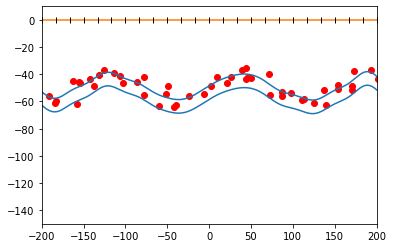

loss tf.Tensor(-218.96430407731862, shape=(), dtype=float64)
grad tf.Tensor(
[-0.09241035 -0.15559019  0.12675069 -0.38531457  0.25688957  0.11610632
  0.04888018  0.13873191  0.12704073 -0.1746084   0.0333484  -0.02940198
 -0.17294729  0.02328006  0.05184214 -0.10341606  0.03857115  0.34277893
  0.22366235 -0.22788722 -0.21594294 -0.29268618  0.16375231 -0.01393068
  0.01182736  0.08611469 -0.19939338  0.18952484 -0.05935687 -0.00633661
 -0.04470072 -0.04239449  0.23765159  0.18804426  0.06226615 -0.29791879
 -0.03229699  0.13536673 -0.08867511 -0.01422931  0.02438637  0.14719731
 -0.26104004 -0.20478856  0.04066636  0.15681535 -0.10716722  0.05517358
  0.22020496 -0.0603284 ], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-57.90433016 -58.98389094 -57.67066768 -56.55379174 -48.51406844
 -48.07132927 -44.20375006 -48.00859952 -38.54586881 -46.04301283
 -41.21393866 -41.01975548 -43.74741997 -39.50294268 -46.44243601
 -53.80444079 -54.83684849 -47.02513924 -51.89439411 -60.32554935
 -59.

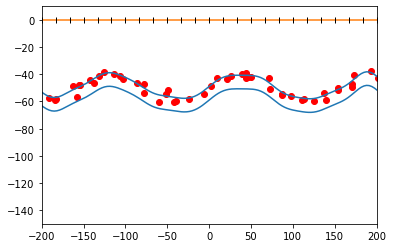

loss tf.Tensor(-226.08202775931306, shape=(), dtype=float64)
grad tf.Tensor(
[-0.0444417  -0.07719505  0.0616146  -0.19766682  0.13519862  0.057977
  0.0194912   0.07006572  0.06640771 -0.09417909  0.0152383  -0.01195082
 -0.08669387  0.01627766  0.02393225 -0.05727249  0.02390508  0.17177978
  0.11976999 -0.11807985 -0.10390423 -0.14319023  0.08154327 -0.01134097
  0.00593241  0.04683328 -0.10051537  0.09603909 -0.02964594 -0.0049194
 -0.02454756 -0.02335974  0.12041335  0.09989375  0.03122904 -0.1494013
 -0.01713484  0.06295071 -0.04006306 -0.010372    0.01080018  0.08036482
 -0.12980659 -0.10825144  0.02048093  0.0802913  -0.0582633   0.0289705
  0.10956337 -0.02622483], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-57.25106577 -57.86769531 -58.57662838 -53.74186948 -50.40891334
 -48.90595457 -44.52152262 -49.0114677  -39.48105706 -44.73762348
 -41.44422741 -40.82791809 -42.50103857 -39.70335885 -46.802445
 -53.02108674 -55.14452083 -49.49717408 -53.55819847 -58.65441504
 -57.8711569

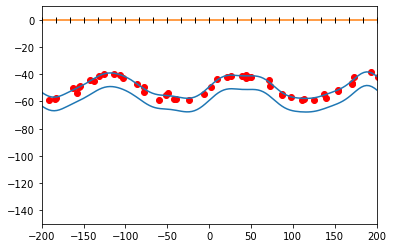

loss tf.Tensor(-227.92585184621726, shape=(), dtype=float64)
grad tf.Tensor(
[-0.0217895  -0.03876114  0.029434   -0.1010941   0.07104907  0.02943546
  0.00802929  0.0358303   0.03447941 -0.04996861  0.00713587 -0.00519628
 -0.04392908  0.00975394  0.01133733 -0.03090722  0.01410991  0.08667396
  0.06366488 -0.0609279  -0.05050962 -0.07057586  0.0400774  -0.00781321
  0.00323784  0.02564996 -0.0505419   0.04848923 -0.01475987 -0.00363442
 -0.01365404 -0.01308873  0.0607761   0.05290509  0.01605541 -0.07495202
 -0.00868962  0.02958384 -0.01852918 -0.00678488  0.00464299  0.04292918
 -0.06520606 -0.056512    0.01031541  0.04107112 -0.03088922  0.0150864
  0.05519174 -0.01209564], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-56.93366951 -57.31031065 -59.01214754 -52.30200854 -51.40596196
 -49.32659794 -44.65057572 -49.52155471 -39.96817855 -44.03973077
 -41.55085995 -40.747092   -41.8724555  -39.8315215  -46.97067258
 -52.59322687 -55.33094063 -50.74043564 -54.44627101 -57.79091755
 -57.1

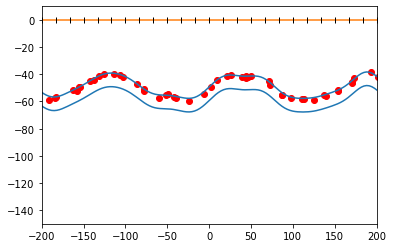

loss tf.Tensor(-228.40555385724625, shape=(), dtype=float64)
grad tf.Tensor(
[-0.01078097 -0.0195618   0.0140986  -0.05169369  0.0371954   0.01501978
  0.00332405  0.0183812   0.01785443 -0.02631057  0.00338185 -0.00232139
 -0.0223458   0.0055473   0.00546445 -0.01647787  0.00803417  0.04388107
  0.03362773 -0.03144528 -0.02469626 -0.03494863  0.01968101 -0.00491018
  0.00180311  0.01396083 -0.02545561  0.02447324 -0.00738159 -0.00242965
 -0.00754461 -0.00727981  0.03067112  0.02791902  0.00830659 -0.03765553
 -0.00435825  0.01397951 -0.00866302 -0.00414046  0.00197228  0.02267077
 -0.03294782 -0.02930964  0.00518722  0.02099051 -0.01616759  0.00782729
  0.02799996 -0.00582344], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-56.7773698  -57.02973936 -59.22031381 -51.5657378  -51.92905097
 -49.54072575 -44.70390559 -49.78285517 -40.22074786 -43.67083027
 -41.60107082 -40.71149063 -41.55333165 -39.90625848 -47.05101339
 -52.3637071  -55.43905578 -51.36876604 -54.91693137 -57.34535363
 -56.

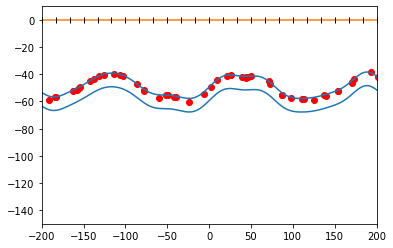

loss tf.Tensor(-228.53074986073085, shape=(), dtype=float64)
grad tf.Tensor(
[-0.00536873 -0.00990511  0.00679844 -0.02644309  0.01940173  0.00768079
  0.0013719   0.00943935  0.00923382 -0.01378377  0.00161906 -0.00105726
 -0.01139455  0.00306932  0.00266946 -0.00871504  0.00446424  0.02226956
  0.01767454 -0.016239   -0.01212486 -0.01736723  0.0096884  -0.00292671
  0.00099863  0.00753408 -0.01284883  0.01236885 -0.00370598 -0.00151184
 -0.00412266 -0.0040032   0.0154988   0.01467736  0.00429801 -0.01895588
 -0.00218602  0.00663133 -0.00406643 -0.00241002  0.00083985  0.01188991
 -0.01671198 -0.01514802  0.00259808  0.01071486 -0.00840421  0.0040581
  0.014264   -0.00288589], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-56.69980441 -56.88792106 -59.3203035  -51.18919521 -52.20244107
 -49.6501066  -44.72596427 -49.91697708 -40.35145342 -43.47705424
 -41.62497512 -40.69544756 -41.39081282 -39.94818825 -47.08997441
 -52.24180564 -55.49989476 -51.68723229 -55.16496048 -57.11533356
 -56.5

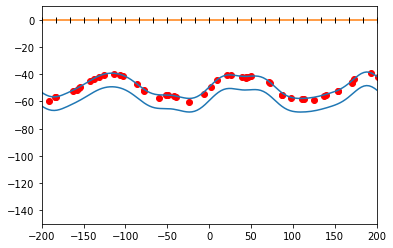

loss tf.Tensor(-228.56350157140187, shape=(), dtype=float64)
grad tf.Tensor(
[-0.00268748 -0.00502814  0.00330275 -0.0135328   0.0100892   0.00393271
  0.00056197  0.00484932  0.00477173 -0.00719403  0.00078234 -0.00049004
 -0.00582082  0.00166858  0.00131946 -0.00458191  0.00243762  0.0113237
  0.00925294 -0.00839088 -0.00597314 -0.00865598  0.0047853  -0.00168591
  0.00054739  0.00403405 -0.00649953  0.00626279 -0.00186675 -0.00089662
 -0.00222904 -0.00217806  0.0078453   0.0076896   0.00221985 -0.00956206
 -0.00110069  0.00315509 -0.00191039 -0.0013581   0.0003619   0.00620677
 -0.00849994 -0.00781261  0.00129586  0.00546365 -0.00435082  0.00210453
  0.00728562 -0.00145875], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-56.66108595 -56.81602723 -59.3686772  -50.99654118 -52.34484335
 -49.7060754  -44.73504204 -49.98586705 -40.41902542 -43.37571635
 -41.63646675 -40.68808433 -41.30787148 -39.97119144 -47.10910843
 -52.17751292 -55.53341978 -51.84899756 -55.29508363 -56.99651555
 -56.5

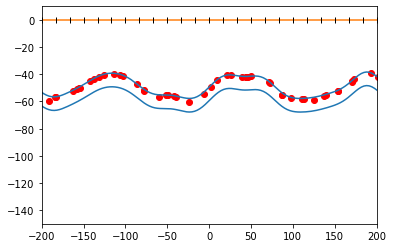

loss tf.Tensor(-228.5720847924502, shape=(), dtype=float64)
grad tf.Tensor(
[-0.00135119 -0.00255765  0.00161618 -0.00692868  0.00523332  0.00201535
  0.00022753  0.00249171  0.00246447 -0.0037437   0.00038129 -0.00023109
 -0.0029778   0.00089588  0.00065907 -0.00239766  0.00131384  0.00576732
  0.00482848 -0.00433758 -0.00295151 -0.00432551  0.00237174 -0.0009484
  0.00029721  0.00214582 -0.00329433  0.00317692 -0.00094304 -0.00051458
 -0.00119449 -0.00117446  0.00397798  0.0040169   0.00114402 -0.00483265
 -0.00055686  0.00150487 -0.00089696 -0.00074815  0.0001589   0.00322909
 -0.00433211 -0.00402389  0.00064412  0.0027838  -0.00224642  0.00109193
  0.00372789 -0.00074761], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-56.64166546 -56.77949734 -59.39225372 -50.89792716 -52.41880826
 -49.73474409 -44.73874345 -50.02126138 -40.45393505 -43.32289838
 -41.64204089 -40.68464555 -41.26547337 -39.98362293 -47.11861098
 -52.14378491 -55.55161329 -51.93131404 -55.3631037  -56.93510815
 -56.46

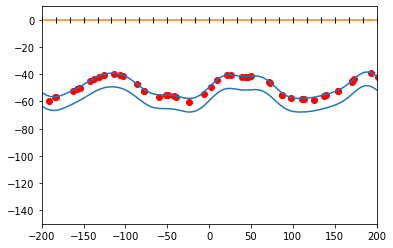

loss tf.Tensor(-228.57433723074809, shape=(), dtype=float64)
grad tf.Tensor(
[-6.81862978e-04 -1.30318108e-03  7.96196594e-04 -3.54876123e-03
  2.70897866e-03  1.03344233e-03  9.05783188e-05  1.28041855e-03
  1.27228297e-03 -1.94362574e-03  1.87309350e-04 -1.10876852e-04
 -1.52517420e-03  4.76592395e-04  3.32269568e-04 -1.24994402e-03
  7.01145155e-04  2.94146083e-03  2.51299088e-03 -2.24295507e-03
 -1.46246272e-03 -2.16660327e-03  1.17936524e-03 -5.24382935e-04
  1.60134837e-04  1.13528210e-03 -1.67273640e-03  1.61427340e-03
 -4.77636629e-04 -2.88554103e-04 -6.35470500e-04 -6.28688167e-04
  2.02020463e-03  2.09323605e-03  5.88407929e-04 -2.44657244e-03
 -2.83014058e-04  7.19307504e-04 -4.20586941e-04 -4.05458764e-04
  7.14671318e-05  1.67558713e-03 -2.21148867e-03 -2.07055774e-03
  3.19339179e-04  1.41768550e-03 -1.15774657e-03  5.66765456e-04
  1.90986982e-03 -3.86840460e-04], shape=(50,), dtype=float64)
mu: tf.Tensor(
[-56.63188481 -56.76090139 -59.40382559 -50.8474289  -52.45713775

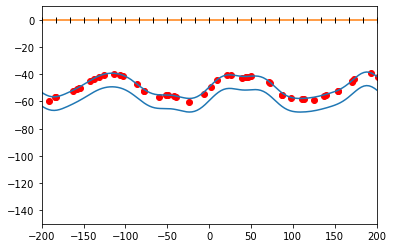

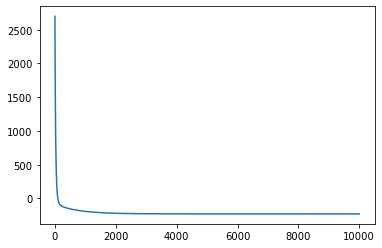

In [176]:
steps_gradient_decent = 10000
lost = []
mu = mu_init
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)

    mu = mu-tf.multiply(constant64(0.01),dlossdmu)
    if i % 1000 == 0:
        print('loss',loss)
        print('grad',dlossdmu)
        print('mu:',mu)
        f,ax = plt.subplots()
        Draw_inter(control_index,mu,ax = ax)
        print('Iteration',i)
        plt.show()
plt.plot(lost)

In [177]:
tf.math.reduce_std(Data)

<tf.Tensor: shape=(), dtype=float64, numpy=2.840466692406105e-07>

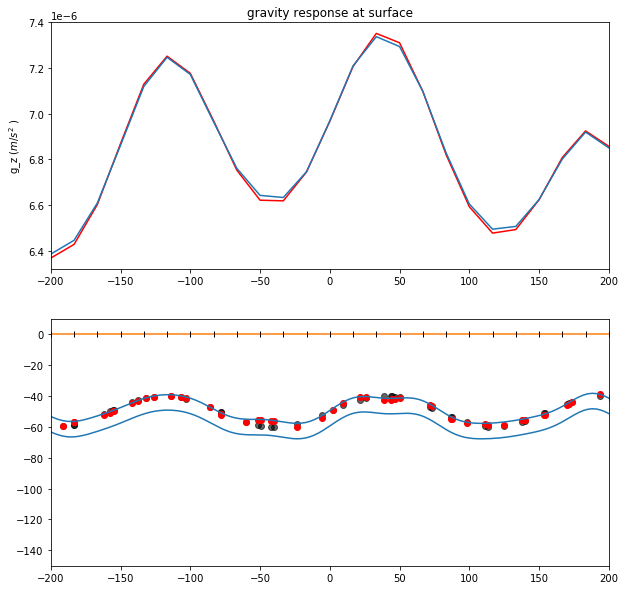

In [178]:
f,ax = plt.subplots(2,figsize =(10,10))
x_obs = np.linspace(Range[0],Range[1],obs_N)
ax[0].plot(x_obs,Data,'r')
Draw(control_index,mu,ax)

In [179]:
MAP = mu

In [180]:
with tf.GradientTape() as t:
    t.watch(MAP)
    with tf.GradientTape() as tt:
        tt.watch(MAP)
        loss = negative_log_posterior(Data,MAP)
    jac = tt.gradient(loss,MAP)
hess = t.gradient(jac,MAP)
MAP = MAP+tf.ones_like(MAP)

In [181]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para)
    j=0
    for i in range(Number_para):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = negative_log_posterior(Data,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()
New_Hessian = Full_Hessian()

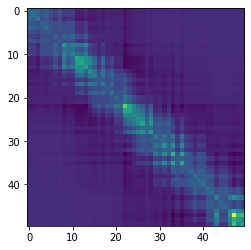

In [182]:
plt.imshow(New_Hessian)

Covariance Matrix, which is the inverse of the Hessian. 

In [204]:
covariance = tf.linalg.inv(New_Hessian)

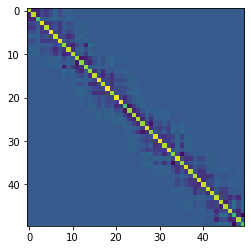

In [184]:
plt.imshow(covariance)

I took off the diagonal to better show this correlation (below). What we can see here is each points has high correlation up to about 5 points next to it. This matches the Gaussian Process scale 20 *2 

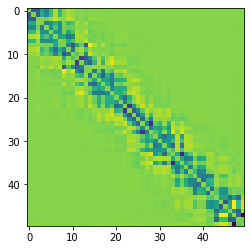

In [185]:
H = covariance.numpy()

for i in range(Number_para):
    H[i,i] = 0
plt.imshow(H)

In [186]:
#TODO
def draw_MCMC(samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots(figsize = (10,5))
    
    x_cor = tf.linspace(Range[0],Range[1],Number_para)
    
    if Truth is not None:
        ax.scatter(x_cor,Truth,c = 'black',alpha = 0.1)
            
    for ps in samples:
        ax.plot(x_cor,ps,'r.',alpha =0.01)
        ps = tf.reshape(ps,[ps.shape[0]])
#         GaussianProcess_model_plot(control_index,ps,ax = ax, alpha = 0.01)
    ax.set_ylim(depth - 100,0)
    ax.set_xlim(-R,R)

In [187]:
# for i in np.linspace(0.01, 0.2,20):
#     beta = constant64(i)
# #     h = HessianMCMC(Number_para,negative_log_posterior,Data,MAP,cov_prior,number_sample,number_burnin,mu_init,beta)
#     h = HessianMCMC(Number_para,negative_log_posterior,Data,MAP,cov_prior,number_sample,number_burnin,MAP,beta)
#     h.run_chain_hessian()
#     print("acceptance rate for beta %0.2f = %0.1f%%" %(i,100*h.acceptance_rate))

acceptance rate = 19.9%


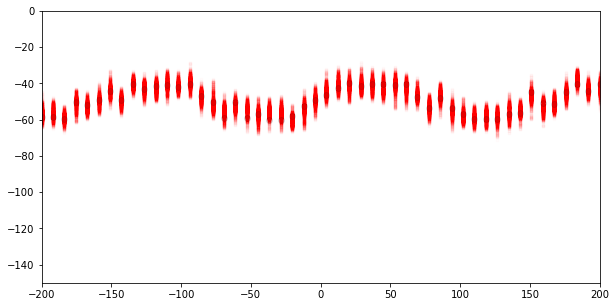

In [201]:
beta = constant64(0.3)
h = HessianMCMC(Number_para,negative_log_posterior,Data,MAP,cov_prior,number_sample,number_burnin,MAP,beta)
h.run_chain_hessian()
print("acceptance rate = %0.1f%%" %(100*h.acceptance_rate))
accepted_gpCN, rejected_gpCN = h.run_chain_hessian()
draw_MCMC(accepted_gpCN,Truth = True_position_sin,R = Range[1])

# plt.savefig('/Users/zhouji/Documents/Results/2D_Gaussian_process/gpCN.png')

In [202]:
accepted_gpCN = np.array(accepted_gpCN)

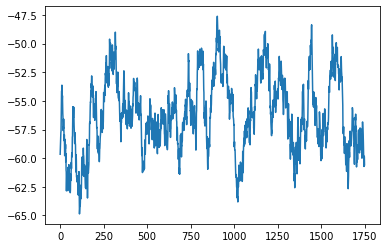

In [203]:
plt.plot(accepted_gpCN[:,1])

## RMH

In [191]:
num_results = number_sample
burnin = number_burnin


initial_chain_state = [
    -100 * tf.ones([Number_para], dtype=tf.float64, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(Data,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float64

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/anaconda3/envs/nightly/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate = 3.9%


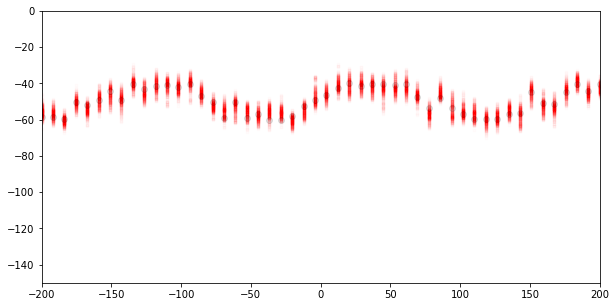

In [192]:
accept_index = np.where(accepted==True)
accepted_samples_RMH = samples[accept_index]

print('Acceptance rate = %0.1f%%' % (100*accepted_samples_RMH.shape[0]/num_results))

draw_MCMC(accepted_samples_RMH,Truth = True_position_sin,R = Range[1])

# plt.savefig('/Users/zhouji/Documents/Results/2D_Gaussian_process/RMH.png')

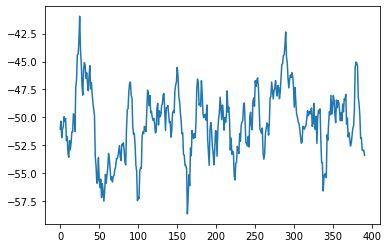

In [193]:
plt.plot(accepted_samples_RMH[:,3])

## HMC

In [194]:
@tf.function
def run_HMC():
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            step_size = 0.2,
            num_leapfrog_steps = 3),
        num_burnin_steps=burnin,
        num_steps_between_results=1,  # Thinning.
        parallel_iterations=1)
    return samples,kernel_results


In [195]:
samples,kernel_results = run_HMC()

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/anaconda3/envs/nightly/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate = 97.7%


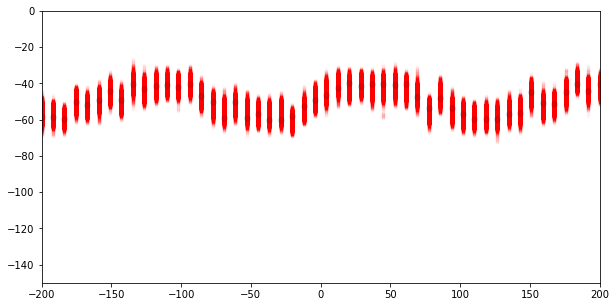

In [196]:
accept_index = np.where(accepted==True)
accepted_samples_HMC = samples[accept_index]

print('Acceptance rate = %0.1f%%' % (100*accepted_samples_HMC.shape[0]/num_results))

draw_MCMC(accepted_samples_HMC,Truth = True_position_sin,R = Range[1])
# plt.savefig('/Users/zhouji/Documents/Results/2D_Gaussian_process/HMC.png')

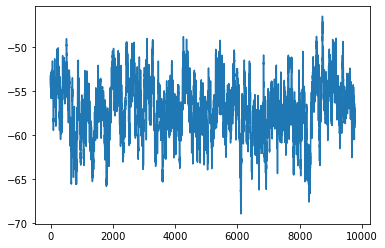

In [197]:
plt.plot(accepted_samples_HMC[:,1])

HMC seems work fine in $D^{50}$. It could be that 

## SVGD

In [304]:
def svgd_kernel(X0):
    XY = tf.matmul(X0, tf.transpose(X0))
    X2_ = tf.reduce_sum(tf.square(X0), axis=1)

    x2 = tf.reshape(X2_, shape=(tf.shape(X0)[0], 1))

    X2e = tf.tile(x2, [1, tf.shape(X0)[0]])
    
    ## (x1 -x2)^2 + (y1 -y2)^2
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e)), 2 * XY)

    V = tf.reshape(H, [-1, 1])

    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(
        0.5 * h / tf.math.log(tf.cast(tf.shape(X0)[0], tf.float64) + 1.0))

    # compute the rbf kernel
    Kxy = tf.exp(-H / h ** 2 / 2.0)

    dxkxy = tf.negative(tf.matmul(Kxy, X0))
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), 1)
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (h ** 2)

    return (Kxy, dxkxy)

In [305]:
mu = tf.random.uniform([num_particles,50],-200,-10,dtype = tf.float64)

In [313]:
def gradient(mu):
    log_p_grad = []
    for i in range(mu.shape[0]):
        with tf.GradientTape() as t:
            t.watch(mu)
            f = joint_log_post(Data,mu[i])
        log_p_grad.append((t.gradient(f,mu)[i].numpy()))
    return np.array(log_p_grad)

In [314]:
lr = constant64(0.001)
num_iter = 10
num_particles = 250

In [315]:
def run_chain_svgd():
    global mu
    for _ in range(num_iter):
        log_p_grad = gradient(mu)
        kernel_matrix, kernel_gradients = svgd_kernel(mu)
        grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
        mu = mu+lr*grad_theta

In [317]:
run_chain_svgd()

<tf.Tensor: shape=(250, 50), dtype=float64, numpy=
array([[-131.42260685,  -64.43127931,  -54.47323927, ..., -175.20773522,
        -101.09314664,  -65.65812063],
       [ -96.76794763, -149.43382116, -157.54247646, ...,  -54.78853723,
        -135.37382441,  -49.85784633],
       [ -45.67422708, -113.30901109, -190.49765629, ..., -101.61469728,
        -147.35299027, -175.7883841 ],
       ...,
       [-121.45394158, -101.44763678, -151.65568512, ...,  -88.2253546 ,
        -153.31953626,  -30.47919257],
       [-116.71337319, -161.09417082,  -78.5893134 , ...,  -21.75323497,
         -39.46709372, -166.38330387],
       [-110.00136709,  -17.97808136, -162.40719184, ..., -194.7140264 ,
        -169.01788772,  -78.50091469]])>